# EURUSD prediction

## Dependencies

In [3]:
from database_operations.DatabaseManager import DatabaseManager
from scripts.HistoricalDataCollector import HistoricalDataCollector
from xapi import PeriodCode
from my_secrets import config

import pandas as pd

### Connection to database and define symbol

In [4]:
SYMBOL = "EURUSD"
database_conn = DatabaseManager(config.DB_FILE)

In [5]:
SYMBOL_ID  = await database_conn.get_specify_data("stock",["id"], f"symbol = ?",(SYMBOL,))
SYMBOL_ID = SYMBOL_ID[0][0]

Connected to db.
Set row factory.


## Download newest EURUSD data and save in db

In [6]:
hist_data_collector = HistoricalDataCollector(
    symbol= SYMBOL,
    start='2000-01-01',
    end='2023-10-10',
    period=PeriodCode.PERIOD_D1,
    credentials_file=config.CREDENTIALS_PATH
)
await hist_data_collector.connect_to_xapi()
await database_conn.populate_prices("stock_price_1d", SYMBOL_ID, SYMBOL, hist_data_collector)

Connected to API.
Last date in the database
2023-10-12 00:00:00
Today's date
2023-10-19 00:00:00
Newest data downloaded
Data for symbol: EURUSD just added to the database.
Disconnected from db.


## Download data from db

In [7]:
COLUMNS = ['date', 'open', 'close', 'high', 'low', 'volume']
columns_with_prefix = [f'sp.{column}' for column in COLUMNS]
columns_list = ', '.join(columns_with_prefix)

In [8]:
QUERY = f"""
        SELECT {columns_list}
        FROM stock s
        JOIN stock_price_1d sp ON s.id = sp.stock_id
        WHERE s.symbol = ?
        """

In [9]:
data_list = await database_conn.execute_custom_query(QUERY, (SYMBOL,))

Connected to db.
Set row factory.


## Create dataframe

In [10]:
data_df = pd.DataFrame(data_list, columns=COLUMNS)

In [11]:
data_df['date'] = data_df['date'].str.split(' ').str[0]

In [12]:
data_df['date'] = pd.to_datetime(data_df['date'])

In [13]:
data_df.set_index('date',inplace=True)

<Axes: xlabel='date'>

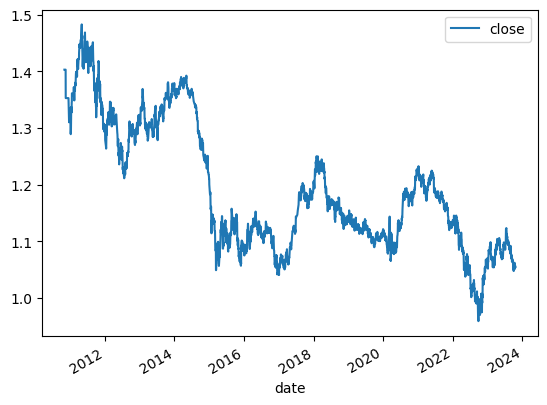

In [14]:
data_df.plot.line(y="close",use_index=True)

# Reinforcement Learning

In [18]:
!pip install tensorflow

  Obtaining dependency information for tensorflow from https://files.pythonhosted.org/packages/80/6f/57d36f6507e432d7fc1956b2e9e8530c5c2d2bfcd8821bcbfae271cd6688/tensorflow-2.14.0-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for tensorflow-intel==2.14.0 from https://files.pythonhosted.org/packages/ad/6e/1bfe367855dd87467564f7bf9fa14f3b17889988e79598bc37bf18f5ffb6/tensorflow_intel-2.14.0-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for absl-py>=1.0.0 from https://files.pythonhosted.org/packages/01/e4/dc0a1dcc4e74e08d7abedab278c795eef54a224363bb18f5692f416d834f/absl_py-2.0.0-py3-none-any.whl.metadata
  Obtaining dependency information for flatbuffers>=23.5.26 from https://files.pythonhosted.org/packages/6f/12/d5c79ee252793ffe845d58a913197bfa02ae9a0b5c9bc3dc4b58d477b9e7/flatbuffers-23.5.26-py2.py3-none-any.whl.metadata
  Using cached flatbuffers-23.5.26-py2.py3-none-any.whl.metadata (850 bytes)
     ----------------------------------------

In [24]:
!pip install gymnasium

  Obtaining dependency information for gymnasium from https://files.pythonhosted.org/packages/a8/4d/3cbfd81ed84db450dbe73a89afcd8bc405273918415649ac6683356afe92/gymnasium-0.29.1-py3-none-any.whl.metadata
  Using cached gymnasium-0.29.1-py3-none-any.whl.metadata (10 kB)
  Using cached cloudpickle-2.2.1-py3-none-any.whl (25 kB)
  Using cached Farama_Notifications-0.0.4-py3-none-any.whl (2.5 kB)
Using cached gymnasium-0.29.1-py3-none-any.whl (953 kB)


In [27]:
!pip install stable-baselines3

In [1]:
!pip install tensorflow[and-cuda]

In [1]:
!pip install gym-anytrading

  Obtaining dependency information for gym-anytrading from https://files.pythonhosted.org/packages/31/97/1c92ae872371577fb4e732ec1365775fa12ce2865233909b5d10dc4f19df/gym_anytrading-2.0.0-py3-none-any.whl.metadata
  Using cached gym_anytrading-2.0.0-py3-none-any.whl.metadata (292 bytes)
Using cached gym_anytrading-2.0.0-py3-none-any.whl (172 kB)



[notice] A new release of pip is available: 23.2.1 -> 23.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [39]:
import gymnasium as gym
import gym_anytrading
import tensorflow as tf
import random


# Stable baselines - rl stuff
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3 import A2C
from stable_baselines3.common.callbacks import BaseCallback

# Processing libraries
import seaborn as sns
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm

In [19]:
data_df = data_df.rename(columns=lambda x: x.capitalize())

In [20]:
env = gym.make('stocks-v0', df=data_df, frame_bound=(5,100), window_size=5)

In [21]:
env.signal_features

C:\Users\jkwia\OneDrive\Pulpit\DYSK PC\Code Proj\GITHUB\XTB_Trading\venv\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.signal_features to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.signal_features` for environment variables or `env.get_wrapper_attr('signal_features')` that will search the reminding wrappers.
  logger.warn(


array([[ 1.403090e+00,  0.000000e+00],
       [ 1.403090e+00, -2.220446e-16],
       [ 1.352900e+00, -5.019000e-02],
       [ 1.352900e+00,  0.000000e+00],
       [ 1.311930e+00, -4.097000e-02],
       [ 1.310280e+00, -1.650000e-03],
       [ 1.310960e+00,  6.800000e-04],
       [ 1.311540e+00,  5.800000e-04],
       [ 1.311280e+00, -2.600000e-04],
       [ 1.316230e+00,  4.950000e-03],
       [ 1.310880e+00, -5.350000e-03],
       [ 1.321670e+00,  1.079000e-02],
       [ 1.329060e+00,  7.390000e-03],
       [ 1.335080e+00,  6.020000e-03],
       [ 1.315010e+00, -2.007000e-02],
       [ 1.300200e+00, -1.481000e-02],
       [ 1.290860e+00, -9.340000e-03],
       [ 1.289280e+00, -1.580000e-03],
       [ 1.294580e+00,  5.300000e-03],
       [ 1.297370e+00,  2.790000e-03],
       [ 1.312810e+00,  1.544000e-02],
       [ 1.334760e+00,  2.195000e-02],
       [ 1.337270e+00,  2.510000e-03],
       [ 1.337000e+00, -2.700000e-04],
       [ 1.327580e+00, -9.420000e-03],
       [ 1.338460e+00,  1

## Build enviroment

In [29]:
def print_stats(reward_over_episodes):
    """  Print Reward  """

    avg = np.mean(reward_over_episodes)
    min = np.min(reward_over_episodes)
    max = np.max(reward_over_episodes)

    print (f'Min. Reward          : {min:>10.3f}')
    print (f'Avg. Reward          : {avg:>10.3f}')
    print (f'Max. Reward          : {max:>10.3f}')

    return min, avg, max

In [35]:
class ProgressBarCallback(BaseCallback):

    def __init__(self, check_freq: int, verbose: int = 1):
        super().__init__(verbose)
        self.check_freq = check_freq

    def _on_training_start(self) -> None:
        """
        This method is called before the first rollout starts.
        """
        self.progress_bar = tqdm(total=self.model._total_timesteps, desc="model.learn()")

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:
            self.progress_bar.update(self.check_freq)
        return True

    def _on_training_end(self) -> None:
        """
        This event is triggered before exiting the `learn()` method.
        """
        self.progress_bar.close()

In [36]:
def train_test_model(model, env, seed, total_num_episodes, total_learning_timesteps=10_000):
    """ if model=None then execute 'Random actions' """

    # reproduce training and test
    print('-' * 80)
    obs = env.reset(seed=seed)
    tf.random.set_seed(seed)
    random.seed(seed)
    np.random.seed(seed)

    vec_env = None

    if model is not None:
        print(f'model {type(model)}')
        print(f'policy {type(model.policy)}')

        model.learn(total_timesteps=total_learning_timesteps, callback=ProgressBarCallback(100))
        # model.learn(total_timesteps=total_learning_timesteps, progress_bar=True)
        # ImportError: You must install tqdm and rich in order to use the progress bar callback.
        # It is included if you install stable-baselines with the extra packages: `pip install stable-baselines3[extra]`

        vec_env = model.get_env()
        obs = vec_env.reset()
    else:
        print ("RANDOM actions")

    reward_over_episodes = []

    tbar = tqdm(range(total_num_episodes))

    for episode in tbar:

        if vec_env:
            obs = vec_env.reset()
        else:
            obs, info = env.reset()

        total_reward = 0
        done = False

        while not done:
            if model is not None:
                action, _states = model.predict(obs)
                obs, reward, done, info = vec_env.step(action)
            else: # random
                action = env.action_space.sample()
                obs, reward, terminated, truncated, info = env.step(action)
                done = terminated or truncated

            total_reward += reward
            if done:
                break

        reward_over_episodes.append(total_reward)

        if episode % 10 == 0:
            avg_reward = np.mean(reward_over_episodes)
            tbar.set_description(f'Episode: {episode}, Avg. Reward: {avg_reward:.3f}')
            tbar.update()

    tbar.close()
    avg_reward = np.mean(reward_over_episodes)

    return reward_over_episodes

In [37]:
env.action_space

Discrete(2)

## Train + test Env

In [38]:
seed = 42  # random seed
total_num_episodes = 50

print ("env_name                 :", env)
print ("seed                     :", seed)

# INIT matplotlib
plot_settings = {}
plot_data = {'x': [i for i in range(1, total_num_episodes + 1)]}

# Random actions
model = None
total_learning_timesteps = 0
rewards = train_test_model(model, env, seed, total_num_episodes, total_learning_timesteps)
min, avg, max = print_stats(rewards)
class_name = f'Random actions'
label = f'Avg. {avg:>7.2f} : {class_name}'
plot_data['rnd_rewards'] = rewards
plot_settings['rnd_rewards'] = {'label': label}

learning_timesteps_list_in_K = [25]
# learning_timesteps_list_in_K = [50, 250, 500]
# learning_timesteps_list_in_K = [500, 1000, 3000, 5000]

# RL Algorithms: https://stable-baselines3.readthedocs.io/en/master/guide/algos.html
model_class_list = [A2C]

for timesteps in learning_timesteps_list_in_K:
    total_learning_timesteps = timesteps * 1000
    step_key = f'{timesteps}K'

    for model_class in model_class_list:
        policy_dict = model_class.policy_aliases
        # https://stable-baselines3.readthedocs.io/en/master/guide/custom_policy.html
        # MlpPolicy or MlpLstmPolicy
        policy = policy_dict.get('MlpPolicy')
        if policy is None:
            policy = policy_dict.get('MlpLstmPolicy')
        # print ('policy:', policy, 'model_class:', model_class)

        try:
            model = model_class(policy, env, verbose=0)
            class_name = type(model).__qualname__
            plot_key = f'{class_name}_rewards_'+step_key
            rewards = train_test_model(model, env, seed, total_num_episodes, total_learning_timesteps)
            min, avg, max, = print_stats(rewards)
            label = f'Avg. {avg:>7.2f} : {class_name} - {step_key}'
            plot_data[plot_key] = rewards
            plot_settings[plot_key] = {'label': label}

        except Exception as e:
            print(f"ERROR: {str(e)}")
            continue

env_name                 : <OrderEnforcing<PassiveEnvChecker<StocksEnv<stocks-v0>>>>
seed                     : 42
--------------------------------------------------------------------------------
RANDOM actions


Episode: 40, Avg. Reward: 0.001: 100%|██████████| 50/50 [00:00<00:00, 1427.35it/s]

Min. Reward          :      0.001
Avg. Reward          :      0.001
Max. Reward          :      0.001


--------------------------------------------------------------------------------
model <class 'stable_baselines3.a2c.a2c.A2C'>
policy <class 'stable_baselines3.common.policies.ActorCriticPolicy'>


Episode: 40, Avg. Reward: 0.055: 100%|██████████| 50/50 [00:01<00:00, 36.20it/s]

Min. Reward          :     -0.025
Avg. Reward          :      0.056
Max. Reward          :      0.126


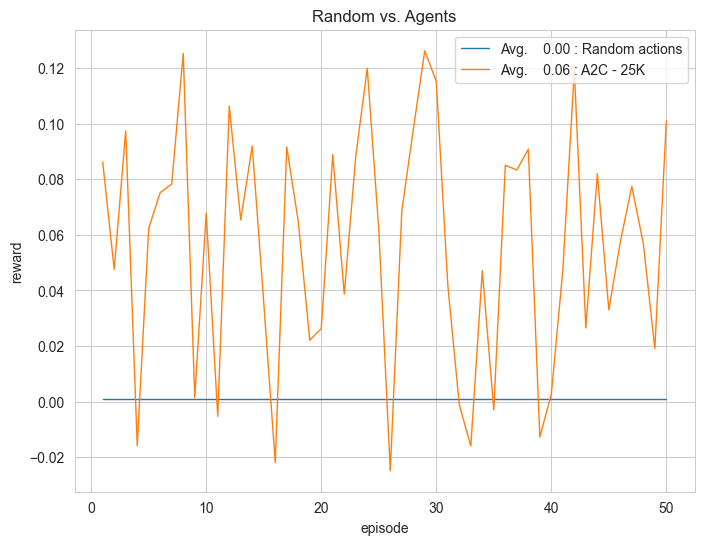

In [41]:
data = pd.DataFrame(plot_data)

sns.set_style('whitegrid')
plt.figure(figsize=(8, 6))

for key in plot_data:
    if key == 'x':
        continue
    label = plot_settings[key]['label']
    line = plt.plot('x', key, data=data, linewidth=1, label=label)

plt.xlabel('episode')
plt.ylabel('reward')
plt.title('Random vs. Agents')
plt.legend()
plt.show()